# GAN - first tries

We are implementing a simple feed-forward GAN architecture on MNIST - just to get the feeling right.

## Loading data

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
(train_data,_),(test_data,_) = mnist.load_data()

In [3]:
# The more the merrier :-)
# Remember, this is unsupervised learning, so "holdout" and such makes less sense
data = np.concatenate((train_data,test_data),axis=0)

In [4]:
data.shape

(70000, 28, 28)

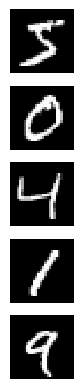

In [5]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [6]:
# Normalization betwenn -1 and 1 !!!!
quasi_mean = data.max()/2 # Max is always 255, so this works ok.
data = (data.astype(np.float32)-quasi_mean)/quasi_mean

In [7]:
# Flattening of the image vectors
data = data.reshape(data.shape[0],-1)
data.shape

(70000, 784)

In [ ]:
# Just to get the feeling, how bad this representation is...

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex].reshape(1,-1), interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [ ]:
EPOCHS = 30
BATCH_SIZE = 200
HALF_BATCH = BATCH_SIZE // 2
BATCH_NUM = (data.shape[0] // BATCH_SIZE)
if data.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1
Z_DIM = 100


### Model parameters

In [ ]:
GENERATOR_L1_DIM = 256
GENERATOR_L2_DIM = 512
GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 512
DISCRIMINATOR_L2_DIM = 256

LEAKY_ALPHA = 0.2

# Add Image Dimension, as recommended below
IMAGE_DIMENSIONS = (28, 28, 1)

## Model building

In [ ]:
import tensorflow as tf
# Some empirically set values. 
# It might well be worth experimenting with newer optimizers / settings

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, beta_1=0.5)

### Generator

In [ ]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model

In [ ]:
### Define the generator!
#########################

# We use FUNCTIONAL API!

# The generator always gets a noise vector as input
noise_input = Input(shape=(Z_DIM,))

# Define the first layer of the fully connected network, without activation!
# Use the parameters defined with capital letter constants in the cells above for node counts!
g_layer_1 = Dense(GENERATOR_L1_DIM)(noise_input)
# Define a non-linearioty, namely leaky relu on this layer!
# We use LeakyReLU for avoiding sparsity - other options are viable also, just not normal relu
# Use the alpha value defined in constants above!
g_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_1)
# You can do this as one layer, but now we do it in two. Does not matter.

# Repeat the process two more times!
g_layer_2 = Dense(GENERATOR_L2_DIM)(g_layer_1_nonlin)
g_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_2)

g_layer_3 = Dense(GENERATOR_L3_DIM)(g_layer_2_nonlin)
g_layer_3_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_3)

# The output of the generator is a flattened image
# Remeber, we normalized everything between -1 and +1, so what is a nice nonlinearity, bounded between
# -1 and 1? 
# Use that one as an activation for the final fully connected layer!
g_output_layer = Dense(np.prod(IMAGE_DIMENSIONS), activation='tanh')(g_layer_3_nonlin)

# Please instantiate the model!
generator = Model(inputs=noise_input, outputs=g_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
# Think about this carefully, please!

### Discriminator

In [ ]:
### Define the discriminator!
#############################

# We still use FUNCTIONAL API!

# The discriminator always gets (flattened) images as inputs
# Where can you find the flattened dimensions? 
# Please use a variable or property, not a hand "baked in" constant.
# That will mess up your life if the data changes...
image_input = Input(shape=IMAGE_DIMENSIONS)

# Following the design pattern from above, please implement two layers with nonlinearities!
d_layer_1 = Dense(DISCRIMINATOR_L1_DIM)(image_input)
d_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_1)

d_layer_2 = Dense(DISCRIMINATOR_L2_DIM)(d_layer_1_nonlin)
d_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_2)

# Please implement the output layer!
# The output of the discriminator is a single binary decision, 
# so one use an appropriate activation and dimensionality!
d_output_layer = Dense(1, activation='sigmoid')(d_layer_2_nonlin)

# Please instantiate the model!
discriminator = Model(inputs=image_input, outputs=d_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

### Joint model

In [ ]:
### Define the GAN itself!
##########################


# STOP!!!!!!
# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = False

# Remove this .... if you understand, why the above line is here!

# What is the input for the whole GAN?
# Think about the case, when the generator generates, the discriminator only discriminates it's output!
gan_input = Input(shape=(Z_DIM,))

# Use the generator as a function on the input!
generated_image = generator(gan_input)
# Use the discriminator as a function on the fake images!
gan_output = discriminator(generated_image)

# Instantiate the joint model, appropriate input and output!
joint_model = Model(inputs=gan_input, outputs=gan_output)

# Please think about, why it can be true, that for the joint model a binary decision is still adequate!
joint_model.compile(loss='binary_crossentropy', optimizer=optimizer)
# Maybe it will get clear below in the training loop...

## Helper functions for visualization

In [ ]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    generated_images = generator.predict(input_noise)
    generated_images = generated_images.reshape(example_count, 28, 28)
    
    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

In [ ]:
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

# Since we do NOT use fit
# sadly, we have to do this ourselves manually
history = {"discriminator":[],"generator":[]}

# Main training loop
for epoch_num in range(EPOCHS):
    epoch_discriminator_loss = 0
    epoch_generator_loss = 0
    
    for batch in tqdm(range(BATCH_NUM)):
        # We select randomly a half batch amount of real images from MNIST
        # Use Numpy to choose, no replacement!
        real_images = train_data[np.random.choice(train_data.shape[0], HALF_BATCH, replace=False)]
        
        # We generate a half batch amount of fake images
        # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
        # and appropriate noise dimensions
        input_noise = np.random.normal(0, 1, (HALF_BATCH, Z_DIM))
        # And then using the fixed generator, to output some images from it
        # Using the predict method of the generator!
        generated_images = generator.predict(input_noise)
        
        # STOP, and thik through, WHY predict?!
        # Then you can remove the ....
        
        # We generate our "labels"
        # Remember one sided label smoothing for the positive class!
        # Let's say with 0.9...
        # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
        # and multiuply it by 0.9
        real_y = np.ones((HALF_BATCH, 1)) * 0.9
        # And generate a half batch worth of zeroes, again one dimensional matrix
        generated_y = np.zeros((HALF_BATCH, 1))

        
        ### We do the actual training!
        
        # First for the discriminator on the real data
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_y)
        
        # Then on the fake data
        discriminator_loss_generated = discriminator.train_on_batch(generated_images, generated_y)
        
        # Then average the two losses
        discriminator_loss = (discriminator_loss_real + discriminator_loss_generated) / 2
        epoch_discriminator_loss += discriminator_loss
        
        ### We then update the generator
        # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model
        
        # Please generate a new set of input noise, notice, it is a full batch!
        # Again, using numpy, normal distribution, zero mean, unit variance
        new_input_noise = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        
        # We try to convince the discriminator, that this is real data - which is not
        # So please generate a batch worht of one dimensional matrix filled with ones 
        convincing_y = np.ones((BATCH_SIZE, 1))
        # Notice, no label smoothing!

        # Remember, the joint model takes in noise, does the generation, the discrimination, then computes loss
        # But the discriminator is frozen, so only the generator will get updated
        # It is "successful" if the discriminator predicts "real" - hence the convincing_y
        generator_loss = joint_model.train_on_batch(new_input_noise, convincing_y)
        epoch_generator_loss += generator_loss
        
    # Loss printout in every epoch, averaged over the batches
    print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, "generator_loss:", epoch_generator_loss / BATCH_NUM)
    
    # Save it for the future
    history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
    history["generator"].append(epoch_generator_loss / BATCH_NUM)
    
    #Save model - optional
    #generator.save("generator.h5")
    
    #Save images
    get_example_images(epoch_num)
    
    # Show epoch example
    show_image_for_epoch(epoch_num)

## Visualization of training progress

In [ ]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
